# Experimentos en el pasillo

Load modules.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from navground import core, sim

plots_dir = os.path.join("plots", "realistic")
os.makedirs(plots_dir, exist_ok=True)

Ejecutamos los experimentos y los guardamos

In [3]:
# Small Corridor
runs={}
length = 15.0
width=1.8
# Large Corridor
# width=1.5
# length = 15.0
num_steps = 300
num_runs = 12
behaviour_list = ["ORCA", "HL", "HRVO", "Dummy"] #si añado el socialForce me da error, kernel restart automatically
marker_behaviour = {"ORCA": "o", "HL": "X", "HRVO": "+", "Dummy": "*"}
color_behaviour = {}
for i, behaviour in enumerate(behaviour_list):
    color_behaviour[behaviour] = mpl.colormaps["Set1"](i / (len(behaviour_list) +1))

In [4]:
for behaviour in behaviour_list:
    yaml = f"""
    steps: {num_steps}
    time_step: 0.1
    record_pose: true
    record_twist: true
    runs: {num_runs}
    record_collisions: true
    record_deadlocks: true
    record_safety_violation: true
    record_efficacy: true
    terminated_when_idle_or_stuck: false
    run_index: 0
    scenario:
      type: Corridor
      length: {length}
      width: {width} 
      groups:
        - number: 10
          type: human
          radius:
            sampler: uniform
            from: 0.15
            to: 0.3
          color: blue
          kinematics:
            type: Ahead
            max_speed: 1.5
            max_angular_speed: 3.0
          behavior:
            type: HL
            optimal_speed: 
              sampler: uniform
              from: 0.7
              to: 1.2
        - number: 3
          type: wheelchair
          color: red
          radius: 0.4
          kinematics:
            type: 2WDiff
            wheel_axis: 0.6
            max_speed: 1.2
          behavior:
            type: {behaviour}
          state_estimation:
            type: Bounded
            range: 5.0
    """
    experiment = sim.load_experiment(yaml)
    experiment.run(number_of_threads=12)
    runs[behaviour] = experiment.runs
    del experiment

Agent does not have a geometric environmental state despite that it is using a geometric state estimation
Agent does not have a geometric environmental state despite that it is using a geometric state estimation
Agent does not have a geometric environmental state despite that it is using a geometric state estimation
Agent does not have a geometric environmental state despite that it is using a geometric state estimation
Agent does not have a geometric environmental state despite that it is using a geometric state estimation
Agent does not have a geometric environmental state despite that it is using a geometric state estimation
Agent does not have a geometric environmental state despite that it is using a geometric state estimation
Agent does not have a geometric environmental state despite that it is using a geometric state estimation
Agent does not have a geometric environmental state despite that it is using a geometric state estimation
Agent does not have a geometric environmental 

## Ahora podemos visualizar alguna ejecución.

In [5]:
from navground.sim.ui.video import display_video, display_video_from_run
from navground.sim import Agent, Wall

def f(entity): #display collisions and deadlocks in the simulation in corridor scenarios
    if isinstance(entity, Agent):
        return {'fill': 'red' if entity.has_been_in_collision_since(run.world.time - 0.5) 
            else 'blue' if entity.has_been_stuck_since(run.world.time - 0.5) 
            else 'lightgreen'}
    elif isinstance(entity, Wall):
        return {'fill': 'red' if entity.has_been_in_collision_since(run.world.time - 0.5) else 'blue'}

run = runs["ORCA"][0]
display_video_from_run(run,factor=3,decorate=f,width=600)

Let us see the performance

In [6]:
import pandas as pd

def count_deadlocks(deadlock_time, initial_time, final_time):
    is_deadlocked = np.logical_and(deadlock_time > initial_time, deadlock_time < (final_time - 5.0))
    return sum(is_deadlocked)

def extract_data(runs, initial_step, final_step):
    collisions = []
    deadlocks = []
    efficacy = []
    sms = []
    seeds = []
    for i, run in runs.items():
        world = run.world
        initial_time, final_time = initial_step*run.time_step, final_step*run.time_step
        deadlocks.append(count_deadlocks(np.array(run.deadlocks), initial_time, final_time))
        collisions.append(np.sum(np.logical_and(
            initial_step < run.collisions[:,0], run.collisions[:,0] < final_step
        )))
        efficacy.append(np.array(run.efficacy[initial_step:final_step]).mean())

    df = pd.DataFrame({
        'deadlocks': deadlocks,
        'collisions': collisions,
        'efficacy': efficacy})
    df['safe'] = (df.collisions == 0).astype(int)
    df['fluid'] = (df.deadlocks == 0).astype(int)
    df['ok'] = ((df.deadlocks == 0) & (df.collisions == 0)).astype(int)
    return df

In [7]:
steps_list = list(range(40, num_steps, 5))
initial_step = steps_list[0]
final_step = steps_list[-1]
deadlocks = {}
collisions = {}
efficacy = {}
for behaviour in behaviour_list:
    df = extract_data(runs[behaviour], initial_step, final_step)
    collisions[behaviour] =  list(df.collisions)
    deadlocks[behaviour] = list(df.deadlocks)
    efficacy[behaviour] = list(df.efficacy)

Ahora visualizamos las métricas de colisión, deadlocks y eficacia

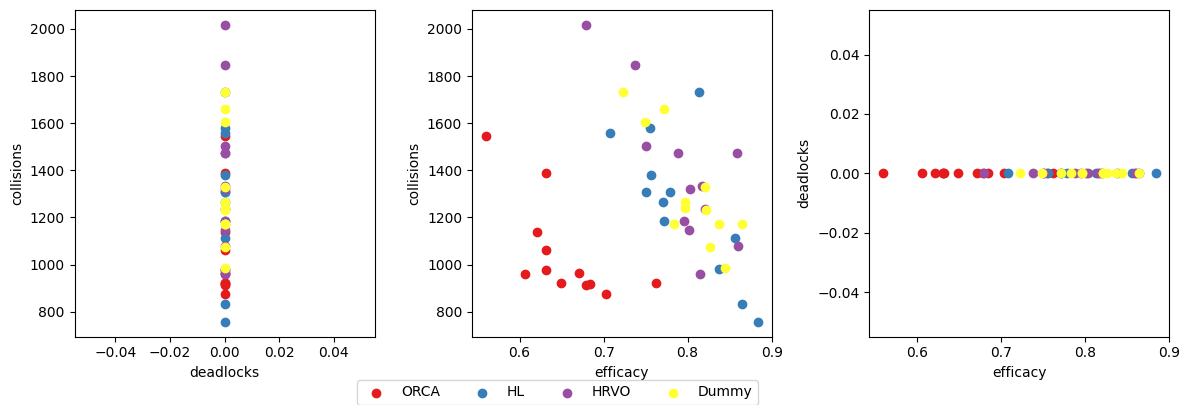

In [8]:
fig, ax = plt.subplots(figsize=(12,4), ncols=3)
for behaviour in behaviour_list:
    ax[0].scatter(deadlocks[behaviour], collisions[behaviour], color=color_behaviour[behaviour], label=behaviour)
    ax[0].set_xlabel("deadlocks")
    ax[0].set_ylabel("collisions")
    ax[1].scatter(efficacy[behaviour], collisions[behaviour], color=color_behaviour[behaviour], label=behaviour)
    ax[1].set_xlabel("efficacy")
    ax[1].set_ylabel("collisions")
    ax[2].scatter(efficacy[behaviour], deadlocks[behaviour], color=color_behaviour[behaviour], label=behaviour)
    ax[2].set_xlabel("efficacy")
    ax[2].set_ylabel("deadlocks")
# end for
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc=(0.3,0),  ncol=len(behaviour_list))
plt.tight_layout()
plt.savefig(os.sep.join((plots_dir, "efficiency_collisions_corridor.png")))